# AWS Forecast Demo with ELE.ai (ARIMA)

In [100]:
# Libraries
import boto3
import datetime
import pandas as pd
from time import sleep
from io import StringIO
import matplotlib.pyplot as plt

## Step 1: Configure the CLI

download SDK files from [github](https://github.com/aws-samples/amazon-forecast-samples/tree/master/sdk) and [configure CLI ](https://docs.aws.amazon.com/forecast/latest/dg/aws-forecast-set-up-aws-cli.html)

In [2]:
! wget https://raw.githubusercontent.com/aws-samples/amazon-forecast-samples/master/sdk/forecast-2018-06-26.normal.json -P setup_files

--2019-05-03 23:24:07--  https://raw.githubusercontent.com/aws-samples/amazon-forecast-samples/master/sdk/forecast-2018-06-26.normal.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.200.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110635 (108K) [text/plain]
Saving to: ‘setup_files/forecast-2018-06-26.normal.json.1’

forecast-2018-06-26 100%[===================>] 108.04K  --.-KB/s    in 0.004s  

2019-05-03 23:24:07 (23.7 MB/s) - ‘setup_files/forecast-2018-06-26.normal.json.1’ saved [110635/110635]



In [3]:
! wget https://raw.githubusercontent.com/aws-samples/amazon-forecast-samples/master/sdk/forecastquery-2018-06-26.normal.json -P setup_files

--2019-05-03 23:24:07--  https://raw.githubusercontent.com/aws-samples/amazon-forecast-samples/master/sdk/forecastquery-2018-06-26.normal.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.200.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10198 (10.0K) [text/plain]
Saving to: ‘setup_files/forecastquery-2018-06-26.normal.json.1’

forecastquery-2018- 100%[===================>]   9.96K  --.-KB/s    in 0s      

2019-05-03 23:24:07 (145 MB/s) - ‘setup_files/forecastquery-2018-06-26.normal.json.1’ saved [10198/10198]



In [4]:
# Configures your AWS CLI to interact with AWS Forecast Service
! aws configure add-model --service-name forecast --service-model file://setup_files/forecast-2018-06-26.normal.json
! aws configure add-model --service-name forecastquery --service-model file://setup_files/forecastquery-2018-06-26.normal.json

## Step 2: Start Boto Session & Define S3 Bucket

In [5]:
session = boto3.Session(region_name='us-east-1') #also available in us-west-2
forecast = session.client(service_name='forecast')
forecastquery = session.client(service_name='forecastquery')

In [6]:
# us-east-1 or us-west-2
! aws s3api create-bucket --bucket forecast-demo-ele --region us-east-1

{
    "Location": "/forecast-demo-ele"
}


## Step 3: Define IAM role 

In [7]:
role_name = 'amazonforecast'
accountId = boto3.client('sts').get_caller_identity().get('Account')
role = 'arn:aws:iam::{}:role/{}'.format(accountId, role_name)

## Step 4: Load & Transform Dataset

### Target Time Series

In [8]:
df1 = pd.read_csv("data/train.csv")
df1.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [9]:
df1.Store = df1.Store.astype('str')
df1.Dept = df1.Dept.astype('str')
df1.IsHoliday = [1 if i else 0 for i in df1.IsHoliday]
df1.Date = df1.Date.astype('datetime64[ns]')

In [10]:
df1.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,0
1,1,1,2010-02-12,46039.49,1
2,1,1,2010-02-19,41595.55,0
3,1,1,2010-02-26,19403.54,0
4,1,1,2010-03-05,21827.90,0


In [11]:
df1 = df1[["Store","Dept","Date","Weekly_Sales"]]
df1.columns = ["location","item_id","timestamp","demand"]
df1 = df1[["timestamp","demand","item_id","location"]]
df1.head()

,timestamp,demand,item_id,location
0,2010-02-05,24924.50,1,1
1,2010-02-12,46039.49,1,1
2,2010-02-19,41595.55,1,1
3,2010-02-26,19403.54,1,1
4,2010-03-05,21827.90,1,1


### Upload to s3

In [12]:
df1.to_csv("data/target.csv", header=True, index=False)
! aws s3 cp data/target.csv s3://forecast-demo-ele/input/target.csv

upload: data/target.csv to s3://forecast-demo-ele/input/target.csv


## Step 5: Create Dataset & Dataset Group in AWS Forecast

In [13]:
schema ={
               "Attributes":[
                  {
                     "AttributeName":"timestamp",
                     "AttributeType":"timestamp"
                  },
                  {
                     "AttributeName":"demand",
                     "AttributeType":"float"
                  },
                  {
                     "AttributeName":"item_id",
                     "AttributeType":"string"
                  },
                   {
                     "AttributeName":"location",
                     "AttributeType":"string"
                  }
               ]
            }

In [14]:
stime = datetime.datetime.now()

forecast.create_dataset(
                        Domain="RETAIL",
                        DatasetType='TARGET_TIME_SERIES',
                        DataFormat='CSV',
                        DatasetName= 'target',
                        DataFrequency="W", 
                        TimeStampFormat="yyyy-MM-dd hh:mm:ss",
                        Schema = schema
                        )

print(datetime.datetime.now() - stime) 

0:00:00.163363


In [15]:
stime = datetime.datetime.now()

groupname = 'eledemo1'
forecast.create_dataset_group(DatasetGroupName=groupname,RoleArn=role,DatasetNames=["target"])
forecast.describe_dataset_group(DatasetGroupName=groupname)

print(datetime.datetime.now() - stime) 

0:00:00.213361


## Step 7: Import Dataset in AWS Forecast

In [16]:
stime = datetime.datetime.now()

path = 's3://forecast-demo-ele/input/target.csv'
import_job =forecast.create_dataset_import_job(
                                                DatasetName='target', 
                                                Delimiter=',', 
                                                DatasetGroupName = groupname, 
                                                S3Uri= path)
vId = import_job['VersionId']
print("DATASET VERSION ID: ", vId)
print("importing dataset...")
while True:
    ImportStatus = forecast.describe_dataset_import_job(DatasetName='target', VersionId=vId)['Status']
    if ImportStatus != 'ACTIVE' and ImportStatus != 'FAILED':
        sleep(10)
    else:
        break
    
if forecast.describe_dataset(DatasetName='target')['Status'] == 'FAILED':
    print("import job failed")
else:
    print(datetime.datetime.now() - stime) 

DATASET VERSION ID:  47169e7d
importing dataset...
0:02:31.376934


## Step 8: Train Predictor Model in AWS Forecast

In [17]:
# View Recipes
forecast.list_recipes()["RecipeNames"]

['forecast_ARIMA',
 'forecast_DEEP_AR',
 'forecast_DEEP_AR_PLUS',
 'forecast_ETS',
 'forecast_MDN',
 'forecast_MLP',
 'forecast_MQRNN',
 'forecast_NPTS',
 'forecast_PROPHET',
 'forecast_RFQR',
 'forecast_SQF']

In [18]:
groupname = 'eledemo1'
recipe = 'forecast_arima'
predictor_name = 'eledemo1_arima'
horizon = 24
stime = datetime.datetime.now()
createPredictorResponse=forecast.create_predictor(
                    RecipeName = recipe, 
                    DatasetGroupName = groupname, 
                    PredictorName = predictor_name, 
                    ForecastHorizon = horizon,
                    RecipeParameters = {
                        "HolidayCalendarName":"US",
                        "GroupByForecastKeys": ["location"]}
                    )
print("training...")
while True:
    predictorStatus = forecast.describe_predictor(PredictorName=predictor_name)['Status']

    if predictorStatus != 'ACTIVE' and predictorStatus != 'FAILED':
        sleep(30)
    elif predictorStatus == 'FAILED':
        print("{} FAILED after {}".format(predictor_name, datetime.datetime.now() - stime ))
    else:
        break
print("Status: {}, training time: {}".format(predictorStatus, datetime.datetime.now() - stime))

training...
Status: ACTIVE, training time: 0:37:09.766027


## Step 9: Evaluate Accuracy

In [22]:
forecastquery.get_accuracy_metrics(
    PredictorName=predictor_name)['ErrorMetrics']['Metrics']

{'p10': '0.06708607710679557',
 'p50': '0.14091718099118966',
 'p90': '0.09521835787233253',
 'rmse': '4612.477657893568'}

## Step 10: Deploy Predictor

In [ ]:
stime = datetime.datetime.now()

forecast.deploy_predictor(PredictorName=predictor_name)

print("deploying {}...".format(predictor_name))
while True:
    deployedPredictorStatus = forecast.describe_deployed_predictor(
        PredictorName=predictor_name)['Status']
    if deployedPredictorStatus != 'ACTIVE' and deployedPredictorStatus != 'FAILED':
        sleep(30)
    else:
        break
print("Status: {}, deployment time: {}".format(predictorStatus, datetime.datetime.now() - stime))

deploying eledemo1_arima...


In [25]:
forecast.list_deployed_predictors()

{'PredictorNames': ['eledemo1_arima'],
 'ResponseMetadata': {'RequestId': 'bf20cd81-0040-4112-b3c0-bd988810ff22',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 04 May 2019 02:37:07 GMT',
   'x-amzn-requestid': 'bf20cd81-0040-4112-b3c0-bd988810ff22',
   'content-length': '37',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

# How To Query AWS Forecast

In [114]:
predictor_name = 'eledemo1_arima'
i, s = "1", "1"
name = predictor_name + "_" + "i{}s{}.csv".format(i,s)
bucket = "forecast-demo-ele"
key = "output/{}".format(name)

In [115]:
forecastResponse = forecastquery.get_forecast(PredictorName=predictor_name,
                                              Interval="week",
                                              Filters={"item_id":i,"location":s})
d = pd.DataFrame.from_dict(forecastResponse['Forecast'])
mean = pd.DataFrame.from_dict(d.loc['mean']['Predictions']).dropna().rename(columns = {'Val':'sales'})
mean["Date"] = pd.to_datetime(mean.Date, format="%Y-%m-%d")
mean.head(n=2)

,Date,sales
0,2012-10-22,11568.519531
1,2012-10-29,18808.304688


In [116]:
p10 = pd.DataFrame.from_dict(d.loc['p10']['Predictions']).dropna().rename(columns = {'Val':'sales'})
p10["Date"] = pd.to_datetime(mean.Date, format="%Y-%m-%d")

p90 = pd.DataFrame.from_dict(d.loc['p90']['Predictions']).dropna().rename(columns = {'Val':'sales'})
p90["Date"] = pd.to_datetime(mean.Date, format="%Y-%m-%d")

### Save Query to S3

In [117]:
csv_buffer = StringIO()
mean.to_csv(csv_buffer, header=True, index=False)
boto3.resource('s3').Object(bucket,key).put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '2D22402E219D0CFD',
  'HostId': 'KHbrkyca5WNCC6QKCmrAndIzx/NllXPBbULa8eotcjWjuC84haoJllnsUxp5kT2scSmfJR7lblY=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'KHbrkyca5WNCC6QKCmrAndIzx/NllXPBbULa8eotcjWjuC84haoJllnsUxp5kT2scSmfJR7lblY=',
   'x-amz-request-id': '2D22402E219D0CFD',
   'date': 'Sat, 04 May 2019 03:28:44 GMT',
   'etag': '"124fbd2f0f1ea8672814d308b954e127"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"124fbd2f0f1ea8672814d308b954e127"'}

# Evaluate Forecast Results

#### Get Historical Data

In [124]:
bucket = "forecast-demo-ele"
key = "inputEa/item_{}/i{}_s{}.csv".format(i,i,s)
obj = boto3.client('s3').get_object(Bucket=bucket, Key=key)
hist = pd.read_csv(obj['Body'])
hist["timestamp"] = pd.to_datetime(hist.timestamp, infer_datetime_format=True)
hist.head()

,timestamp,demand
0,2010-02-05,24924.50
1,2010-02-12,46039.49
2,2010-02-19,41595.55
3,2010-02-26,19403.54
4,2010-03-05,21827.90


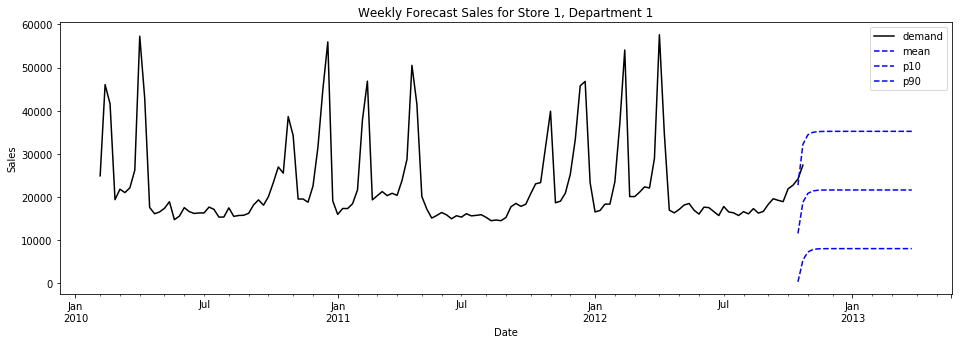

In [126]:
fig, ax = plt.subplots(figsize=(16,5))
hist.plot(x="timestamp",y="demand",ax=ax, color='black')
mean.plot(x="Date",y="sales",ax=ax, color='blue', style='--', label="mean")
p10.plot(x="Date",y="sales",ax=ax, color='blue', style='--', label="p10")
p90.plot(x="Date",y="sales",ax=ax, color='blue', style='--', label="p90")
ax.set_title("Weekly Forecast Sales for Store 1, Department 1")
ax.set_ylabel("Sales")
plt.show()